In [ ]:
### SVM and SVR

In [99]:
# IMPORTS
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline

C:\Users\shahr\AppData\Local\conda\conda\envs\DataScience\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [49]:
# LOAD DATA
dataframe = pd.read_csv('ML\data\dynamic_pus_using_pus50000_15PUs_201910_2616_25.txt', delimiter=',', header=None)
dataframe_max = pd.read_csv('ML\data\dynamic_pus_max_power50000_15PUs_201910_2616_25.txt', delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1]]], axis=1,
                        ignore_index=True)
idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
                           dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
y_class_power = dataframe_tot.values[:, -1]
del dataframe, dataframe_max

In [87]:
# INIT
number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 4001, 1000))
# number_samples = [4000]
C_vec = list(np.arange(0.1, 10, 0.5))

In [51]:
# Splitting data
def split_data(data, train_samples):
    num_inputs = data.shape[1] - 1
    val_samples = round(train_samples/3)
    X_train, y_train = data[0:train_samples, 0: num_inputs], data[0:train_samples, -1]
    X_val, y_val = data[train_samples:train_samples+val_samples, 0: num_inputs],data[train_samples:train_samples+val_samples, -1]
    X_test, y_test = data[train_samples:, 0: num_inputs], data[train_samples:, -1]
    return X_train,X_val, X_test, y_train, y_val, y_test

def false_analysis(y_test, y_pred):
    tp = sum(y_pred[y_test==1])
    fp = sum(y_pred) - tp
    return fp, sum(y_test) - tp

In [88]:
## SVM(SVC)
average_class_diff_power = []
fp_mean_power = []
accuracy, f_score, false_positive, false_negative = [], [], [], []
best_c_lst = []
fp_penalty_coef, fn_penalty_coef = 1, 1
metric = "fp_min"  # {"accuracy", "fp_min"}
class_weight = {0:fp_penalty_coef/(fp_penalty_coef + fn_penalty_coef), 1:fn_penalty_coef/(fp_penalty_coef + fn_penalty_coef)}
best_c, bestsvcclassifier = None, None
for number_sample in number_samples:
    best_accuracy = -float('inf')
    best_fp = float('inf')
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_class, number_sample)
    scaler_x = StandardScaler()
    scaler_x.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_val = scaler_x.transform(X_val)
    for c in C_vec:
        svclassifier = SVC(kernel='rbf', C=c, class_weight = class_weight)
        svclassifier.fit(X_train, y_train)
        
        #validating
        y_pred_val = svclassifier.predict(X_val)
        if metric == "accuracy":
            accuracy_tmp = metrics.accuracy_score(y_val, y_pred_val)
            if accuracy_tmp > best_accuracy:
                best_accuracy = accuracy_tmp
                best_c = c
                bestsvcclassifier = svclassifier
        elif metric == "fp_min":
            conf_mat = metrics.confusion_matrix(y_val, y_pred_val)
            fp_tmp = conf_mat[0][1] if len(conf_mat) == 2 else 0
            if fp_tmp < best_fp:
                best_fp = fp_tmp
                best_c = c
                bestsvcclassifier = svclassifier
                    
            
    best_c_lst.append(best_c)
    #predicting
    X_test = scaler_x.transform(X_test)
    y_pred = bestsvcclassifier.predict(X_test)
    
    #evaluating
    accuracy.append(round(metrics.accuracy_score(y_test, y_pred), 3))
    f_score.append(round(metrics.f1_score(y_true=y_test, y_pred=y_pred), 3))
    fp, fn = false_analysis(y_test, y_pred)
    false_positive.append(int(fp))
    false_negative.append(int(fn))
    
    #Power max calculations
    y_class_power_test = y_class_power[len(y_class_power)-X_test.shape[0]:]
    y_class_power_pred = np.zeros(y_class_power_test.size)
    max_power = max(y_class_power_test) + 10  # 10 is added to increase higher bound
    min_power = min(y_class_power_test) - 10  # 10 is subtracted to decrease lower bound
    for i in range(len(y_class_power_test)):
        h = max_power
        l = min_power
        while h - l > 0.5:
            mid = l + (h - l)/2;
            mid_norm = (mid - scaler_x.mean_[-1])/scaler_x.scale_[-1]
            X_test[i][-1] = mid_norm
            res_tmp = bestsvcclassifier.predict(X_test[i:i+1])
            if res_tmp[0]:
                l = mid
            else:
                h = mid
        y_class_power_pred[i] = l + (h - l)/2
    average_class_diff_power.append(round(np.mean(np.absolute(y_class_power_pred - y_class_power_test)), 3))
    fp_samples = np.zeros(len(y_class_power_pred), dtype=float)
    fp_samples[y_class_power_pred > y_class_power_test] = (y_class_power_pred - y_class_power_test)[y_class_power_pred > 
                                                                                                    y_class_power_test]
    fp_mean_power.append(round(np.mean(fp_samples), 3))
    print('Number_samples:', number_sample, ', accuracy:', accuracy[-1], ', f_score:', f_score[-1], 
          ', fp:', fp,', fn:', fn, ', error:', average_class_diff_power[-1], 'fp_error:', fp_mean_power[-1])
del svclassifier

C:\Users\shahr\AppData\Local\conda\conda\envs\DataScience\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Number_samples: 5 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23632.0 , error: 64.345 fp_error: 0.0
Number_samples: 10 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23629.0 , error: 64.345 fp_error: 0.0
Number_samples: 20 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23626.0 , error: 64.346 fp_error: 0.0
Number_samples: 30 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23621.0 , error: 64.346 fp_error: 0.0
Number_samples: 40 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23617.0 , error: 64.345 fp_error: 0.0
Number_samples: 50 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23615.0 , error: 64.345 fp_error: 0.0
Number_samples: 60 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23609.0 , error: 64.344 fp_error: 0.0
Number_samples: 70 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23603.0 , error: 64.344 fp_error: 0.0
Number_samples: 80 , accuracy: 0.524 , f_score: 0.0 , fp: 0.0 , fn: 23598.0 , error: 64.344 fp_error: 0.0
Number_samples: 90 , accuracy: 0.524 , f_score:

In [89]:
print(average_class_diff_power)
print(fp_mean_power)

[64.345, 64.345, 64.346, 64.346, 64.345, 64.345, 64.344, 64.344, 64.344, 64.345, 64.345, 64.346, 64.346, 64.348, 64.347, 64.347, 64.349, 64.349, 64.351, 55.584, 10.334, 4.977, 5.12]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.376, 2.644, 2.616]


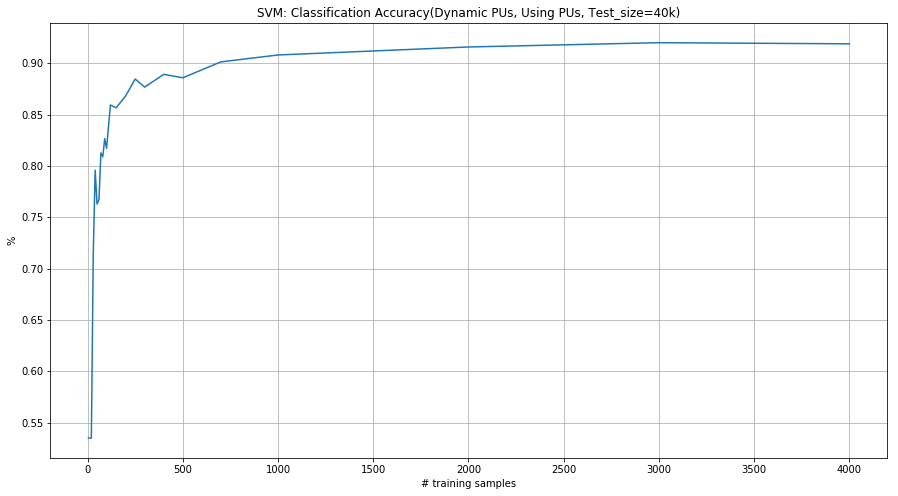

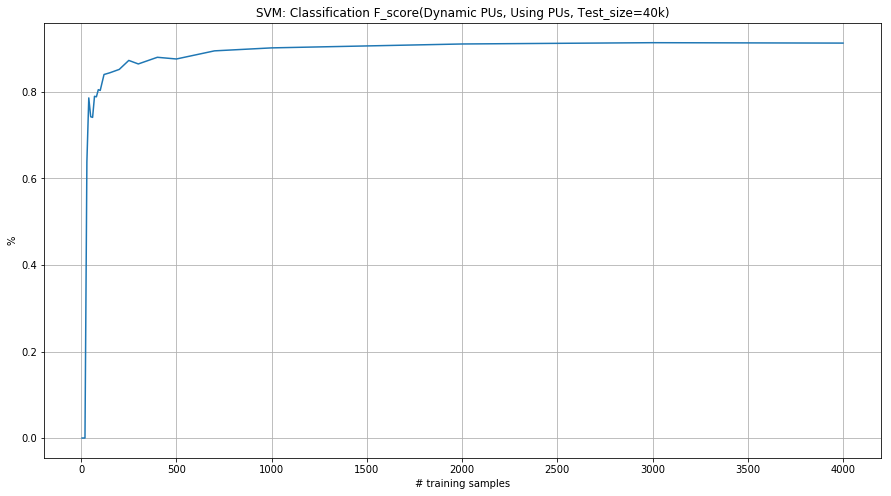

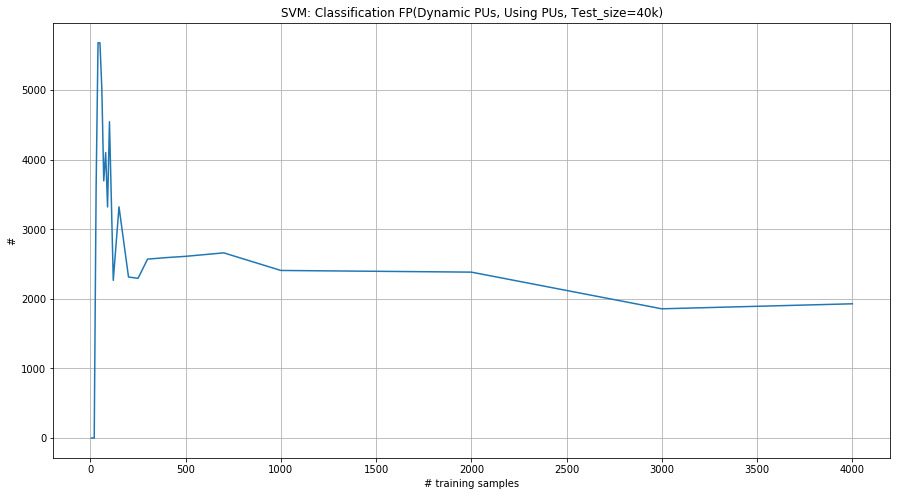

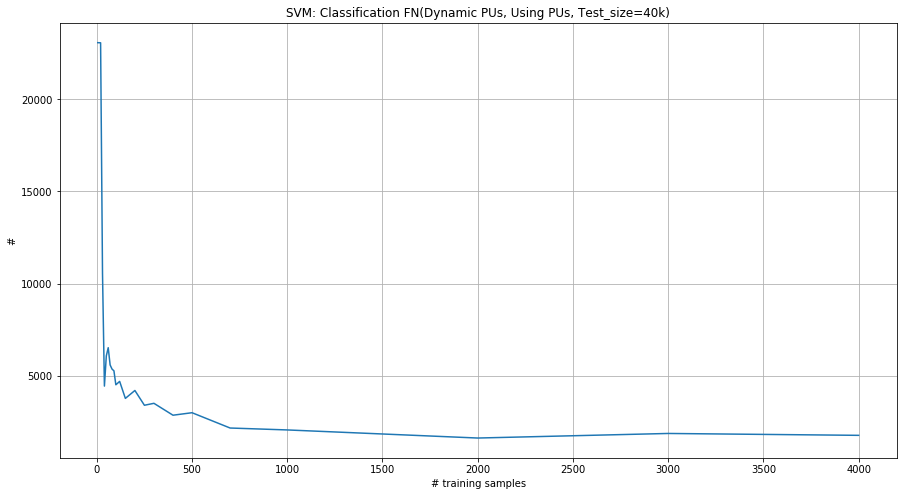

In [40]:
### MAX_POWER ANAlysis
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, accuracy)
plt.xlabel('# training samples')
plt.ylabel('%')
plt.title('SVM: Classification Accuracy(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmAcc.png')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, f_score)
plt.xlabel('# training samples')
plt.ylabel('%')
plt.title('SVM: Classification F_score(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmfscore.png')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, false_positive)
plt.xlabel('# training samples')
plt.ylabel('#')
plt.title('SVM: Classification FP(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmfp.png')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, false_negative)
plt.xlabel('# training samples')
plt.ylabel('#')
plt.title('SVM: Classification FN(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_svmfn.png')

In [95]:
# SVR
average_reg_diff_power, best_c_reg_lst, fp_mean_power = [], [], []
best_c_reg, bestsvrclassifier =  None, None
# TODO: Having different penalties for fp and fn
for number_sample in number_samples:
    min_err = float('inf')
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_reg, number_sample)
    scaler_x = StandardScaler()
    scaler_x.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_val = scaler_x.transform(X_val)
    for c in C_vec:
        svrlassifier = SVR(kernel='rbf', C=c, degree=X_train.shape[1]+1)
        svrlassifier.fit(X_train, y_train)
        
        #validating
        y_pred_val = svrlassifier.predict(X_val)
        err_tmp = np.mean(np.absolute(y_pred_val - y_val))
        if err_tmp < min_err:
            min_err = err_tmp
            best_c_reg = c
            bestsvrclassifier = svrlassifier
            
    best_c_reg_lst.append(best_c_reg)
    #predicting
    X_test = scaler_x.transform(X_test)
    y_pred = bestsvrclassifier.predict(X_test)
    
    
    #evaluating
    average_reg_diff_power.append(round(np.mean(np.absolute(y_test - y_pred)), 3))
    fp_samples = np.zeros(len(y_test), dtype=float)
    fp_samples[y_pred > y_test] = (y_pred - y_test)[y_pred > y_test]
    fp_mean_power.append(round(np.mean(fp_samples), 3))
    print('Number_samples: ', number_sample, ' error: ', average_reg_diff_power[-1], ', fp_error:', fp_mean_power[-1])

Number_samples:  5  error:  5.248 , fp_error: 2.107
Number_samples:  10  error:  5.277 , fp_error: 1.974
Number_samples:  20  error:  5.435 , fp_error: 1.823
Number_samples:  30  error:  5.039 , fp_error: 2.598
Number_samples:  40  error:  5.049 , fp_error: 2.994
Number_samples:  50  error:  5.007 , fp_error: 2.86
Number_samples:  60  error:  5.023 , fp_error: 3.077
Number_samples:  70  error:  5.088 , fp_error: 3.104
Number_samples:  80  error:  5.042 , fp_error: 3.186
Number_samples:  90  error:  5.035 , fp_error: 2.956
Number_samples:  100  error:  5.007 , fp_error: 2.906
Number_samples:  120  error:  5.063 , fp_error: 2.979
Number_samples:  150  error:  4.988 , fp_error: 2.816
Number_samples:  200  error:  4.901 , fp_error: 2.617
Number_samples:  250  error:  4.881 , fp_error: 2.753
Number_samples:  300  error:  4.845 , fp_error: 2.826
Number_samples:  400  error:  4.782 , fp_error: 2.702
Number_samples:  500  error:  4.732 , fp_error: 2.74
Number_samples:  700  error:  4.72 , fp_e

In [98]:
# Linear SVR
average_reg_diff_power, best_c_reg_lst, fp_mean_power = [], [], []
best_c_reg, bestsvrclassifier =  None, None
for number_sample in number_samples:
    min_err = float('inf')
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_reg, number_sample)
    scaler_x = StandardScaler()
    scaler_x.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_val = scaler_x.transform(X_val)
    for c in C_vec:
        svrlassifier = LinearSVR(C=c, loss='epsilon_insensitive')
        svrlassifier.fit(X_train, y_train)
        
        #validating
        y_pred_val = svrlassifier.predict(X_val)
        err_tmp = np.mean(np.absolute(y_pred_val - y_val))
        if err_tmp < min_err:
            min_err = err_tmp
            best_c_reg = c
            bestsvrclassifier = svrlassifier
            
    best_c_reg_lst.append(best_c_reg)
    #predicting
    X_test = scaler_x.transform(X_test)
    y_pred = bestsvrclassifier.predict(X_test)
    
    
    #evaluating
    average_reg_diff_power.append(round(np.mean(np.absolute(y_test - y_pred)), 3))
    fp_samples = np.zeros(len(y_test), dtype=float)
    fp_samples[y_pred > y_test] = (y_pred - y_test)[y_pred > y_test]
    fp_mean_power.append(round(np.mean(fp_samples), 3))
    print('Number_samples: ', number_sample, ' error: ', average_reg_diff_power[-1], ', fp_error:', fp_mean_power[-1])

Number_samples:  5  error:  6.067 , fp_error: 2.019
Number_samples:  10  error:  6.175 , fp_error: 1.365
Number_samples:  20  error:  6.269 , fp_error: 1.64
Number_samples:  30  error:  7.016 , fp_error: 3.023
Number_samples:  40  error:  6.294 , fp_error: 1.857
Number_samples:  50  error:  6.515 , fp_error: 2.402
Number_samples:  60  error:  6.912 , fp_error: 2.618
Number_samples:  70  error:  6.758 , fp_error: 2.697
Number_samples:  80  error:  6.75 , fp_error: 2.7
Number_samples:  90  error:  6.703 , fp_error: 2.526
Number_samples:  100  error:  6.88 , fp_error: 3.688
Number_samples:  120  error:  6.368 , fp_error: 2.326
Number_samples:  150  error:  5.936 , fp_error: 2.205
Number_samples:  200  error:  5.362 , fp_error: 2.524
Number_samples:  250  error:  5.289 , fp_error: 2.604
Number_samples:  300  error:  4.968 , fp_error: 2.732
Number_samples:  400  error:  4.854 , fp_error: 2.698
Number_samples:  500  error:  4.863 , fp_error: 2.705
Number_samples:  700  error:  4.77 , fp_erro

In [97]:
print(average_reg_diff_power)
print(fp_mean_power)

[6.131, 6.181, 8.14, 7.735, 7.062, 7.017, 6.474, 6.063, 5.944, 5.998, 5.776, 5.734, 5.7, 5.904, 5.299, 5.292, 4.999, 4.913, 4.811, 4.773, 4.678, 4.699, 4.66]
[1.94, 2.048, 1.066, 3.376, 2.448, 2.56, 2.833, 2.732, 2.71, 2.409, 2.442, 2.792, 2.604, 2.52, 2.43, 2.338, 2.262, 2.328, 2.321, 2.35, 2.38, 2.312, 2.332]


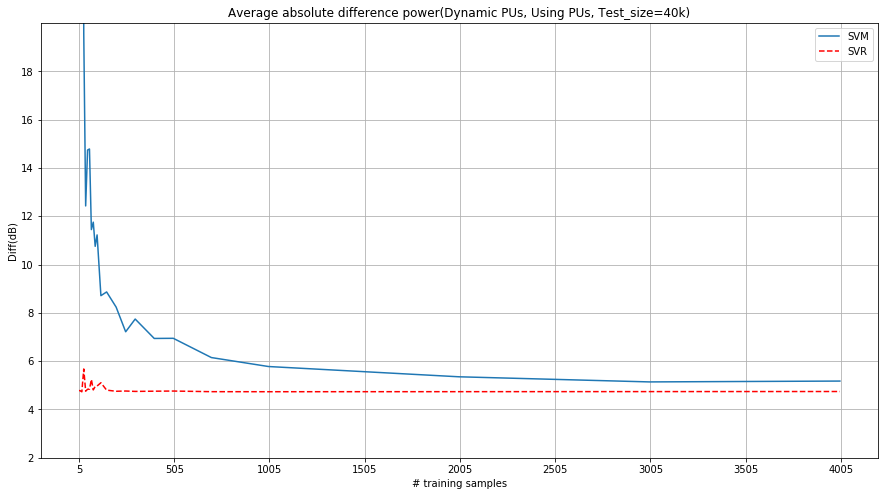

In [48]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_class_diff_power)
plt.plot(number_samples, average_reg_diff_power, 'r--')
plt.xlabel('# training samples')
plt.ylabel('Diff(dB)')
plt.title('Average absolute difference power(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)

ax.set_yticks(np.arange(0,20, 2))
ax.set_ylim([2,20])
ax.set_xticks(np.arange(5,4100, 500))
# plt.grid(which='minor')
# plt.text(40, 50, '# Validation = 34k')
# plt.text(400, 45, '# Test = 34k')
plt.legend(['SVM', 'SVR'])
plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_averag_powerSVMSVR.png')

In [61]:
average_reg_diff_power_tot = []


In [77]:
print(number_samples)

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400, 500, 700, 1000, 2000, 3000, 4000]


In [68]:
average_reg_diff_power_tot.append(average_reg_diff_power)

In [72]:
number_samples = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400, 500, 700, 1000, 2000, 3000, 4000]
average_reg_diff_power_tot = [[4.91, 4.915, 5.02, 7.274, 5.21, 5.476, 5.547, 5.448, 5.358, 5.486, 5.424, 5.585, 5.423, 5.369,
                               5.275, 5.22, 5.065, 5.058, 4.915, 4.873, 4.8, 4.787, 4.782], 
                              [4.739, 4.728, 4.858, 4.9, 4.761, 4.835, 4.898, 4.959, 4.806, 4.913, 4.945, 4.88, 4.8, 4.812,
                               4.756, 4.74, 4.764, 4.832, 4.729, 4.745, 4.728, 4.728, 4.731], 
                              [5.59, 5.33, 4.764, 4.731, 4.728, 4.923, 5.086, 4.798, 4.816, 5.035, 4.827, 4.842, 4.757, 4.796,
                               4.734, 4.748, 4.74, 4.734, 4.728, 4.729, 4.726, 4.726, 4.728], 
                              [4.791, 4.781, 4.732, 5.677, 4.757, 4.837, 4.841, 5.242, 4.81, 4.955, 4.972, 5.106, 4.801, 4.754,
                               4.764, 4.748, 4.757, 4.763, 4.737, 4.735, 4.737, 4.74, 4.744]]

[[4.91, 4.915, 5.02, 7.274, 5.21, 5.476, 5.547, 5.448, 5.358, 5.486, 5.424, 5.585, 5.423, 5.369, 5.275, 5.22, 5.065, 5.058, 4.915, 4.873, 4.8, 4.787, 4.782], [4.739, 4.728, 4.858, 4.9, 4.761, 4.835, 4.898, 4.959, 4.806, 4.913, 4.945, 4.88, 4.8, 4.812, 4.756, 4.74, 4.764, 4.832, 4.729, 4.745, 4.728, 4.728, 4.731], [5.59, 5.33, 4.764, 4.731, 4.728, 4.923, 5.086, 4.798, 4.816, 5.035, 4.827, 4.842, 4.757, 4.796, 4.734, 4.748, 4.74, 4.734, 4.728, 4.729, 4.726, 4.726, 4.728], [4.791, 4.781, 4.732, 5.677, 4.757, 4.837, 4.841, 5.242, 4.81, 4.955, 4.972, 5.106, 4.801, 4.754, 4.764, 4.748, 4.757, 4.763, 4.737, 4.735, 4.737, 4.74, 4.744]]


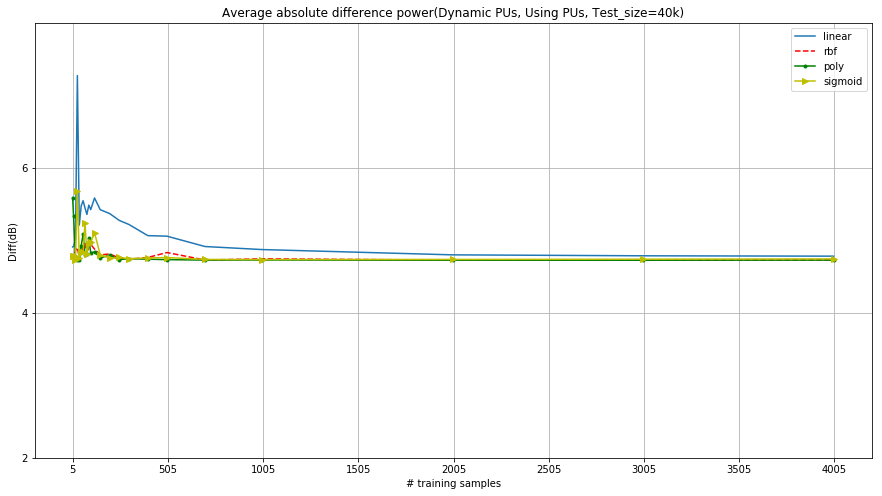

In [75]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_reg_diff_power_tot[0])
plt.plot(number_samples, average_reg_diff_power_tot[1], 'r--')
plt.plot(number_samples, average_reg_diff_power_tot[2], 'g.-')
plt.plot(number_samples, average_reg_diff_power_tot[3], 'y->')
plt.xlabel('# training samples')
plt.ylabel('Diff(dB)')
plt.title('Average absolute difference power(Dynamic PUs, Using PUs, Test_size=40k)')
plt.grid(True)

ax.set_yticks(np.arange(0,8, 2))
ax.set_ylim([2,8])
ax.set_xticks(np.arange(5,4100, 500))
# plt.grid(which='minor')
# plt.text(40, 50, '# Validation = 34k')
# plt.text(400, 45, '# Test = 34k')
plt.legend(['linear', 'rbf', 'poly', 'sigmoid'])
# plt.savefig('ML\\results\\changing_training_test40k_4kx4k_smallVal_compare_dynamicPUS_averag_powerSVMSVR.png')